In [1]:
import os
import librosa
import numpy as np

# 오디오 설정
SAMPLE_RATE = 16000
FRAME_SIZE = 1024
HOP_LENGTH = 512

def extract_freq_amp_phase(frame, sr):
    stft = librosa.stft(frame, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
    magnitude, phase = np.abs(stft), np.angle(stft)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=FRAME_SIZE)
    dominant_bin = np.argmax(magnitude[:, 0])
    freq = freqs[dominant_bin]
    amp = np.mean(magnitude[dominant_bin])
    phase_val = phase[dominant_bin][0]
    return np.array([freq, amp, phase_val])

def extract_features_from_file(file_path, sr=SAMPLE_RATE):
    y, _ = librosa.load(file_path, sr=sr)
    features = []
    for i in range(0, len(y) - FRAME_SIZE, HOP_LENGTH):
        frame = y[i:i+FRAME_SIZE]
        feat = extract_freq_amp_phase(frame, sr)
        features.append(feat)
    return np.array(features)

# 모든 .wav 파일에서 특성 추출
def extract_all_features(wav_dir="./wav"):
    all_features = []
    for filename in os.listdir(wav_dir):
        if filename.endswith(".wav"):
            file_path = os.path.join(wav_dir, filename)
            print(f"📂 Processing: {filename}")
            feats = extract_features_from_file(file_path)
            all_features.append(feats)
    return np.vstack(all_features)  # 모든 파일의 결과를 하나로 합침

# 사용 예
features = extract_all_features()
print("✅ 전체 특성 shape:", features.shape)  # (전체 프레임 수, 3)

📂 Processing: noise1.wav
📂 Processing: noise10.wav
📂 Processing: noise100.wav
📂 Processing: noise1000.wav
📂 Processing: noise1001.wav
📂 Processing: noise1002.wav
📂 Processing: noise1003.wav
📂 Processing: noise1004.wav
📂 Processing: noise1005.wav
📂 Processing: noise1006.wav
📂 Processing: noise1007.wav
📂 Processing: noise1008.wav
📂 Processing: noise1009.wav
📂 Processing: noise101.wav
📂 Processing: noise1010.wav
📂 Processing: noise1011.wav
📂 Processing: noise1012.wav
📂 Processing: noise1013.wav
📂 Processing: noise1014.wav
📂 Processing: noise1015.wav
📂 Processing: noise1016.wav
📂 Processing: noise1017.wav
📂 Processing: noise1018.wav
📂 Processing: noise1019.wav
📂 Processing: noise102.wav
📂 Processing: noise1020.wav
📂 Processing: noise1021.wav
📂 Processing: noise1022.wav
📂 Processing: noise1023.wav
📂 Processing: noise1024.wav
📂 Processing: noise1025.wav
📂 Processing: noise1026.wav
📂 Processing: noise1027.wav
📂 Processing: noise1028.wav
📂 Processing: noise1029.wav
📂 Processing: noise103.wav
📂

In [2]:
import numpy as np

def create_sequences(features, window_size=5):
    X, y = [], []
    for i in range(len(features) - window_size):
        seq_x = features[i:i+window_size]      # 입력: 5프레임 (window)
        seq_y = features[i+window_size]        # 출력: 다음 프레임
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [3]:
# 이전 단계에서 features = (전체 프레임 수, 3)
X, y = create_sequences(features, window_size=5)

print("X shape:", X.shape)  # (샘플 수, 5, 3)
print("y shape:", y.shape)  # (샘플 수, 3)

X shape: (82375, 5, 3)
y shape: (82375, 3)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import joblib

# X: (samples, 5, 3), y: (samples, 3) 형태라고 가정

def preprocess_and_scale(X, y):
    # 1. X reshape: (samples, 5, 3) -> (samples, 15)
    X_reshaped = X.reshape(X.shape[0], -1)

    # 2. MinMaxScaler 생성 및 적합
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()

    # 3. X, y 스케일링
    X_scaled = scaler_x.fit_transform(X_reshaped)
    y_scaled = scaler_y.fit_transform(y)

    # 4. X 다시 reshape: (samples, 15) -> (samples, 5, 3)
    X_scaled = X_scaled.reshape(X.shape)

    # 5. 스케일러 저장
    joblib.dump(scaler_x, "scaler_x.joblib")
    joblib.dump(scaler_y, "scaler_y.joblib")

    print(f"✅ X 정규화 완료: {X_scaled.shape}")
    print(f"✅ y 정규화 완료: {y_scaled.shape}")

    return X_scaled, y_scaled, scaler_x, scaler_y

# 사용 예시
X_scaled, y_scaled, scaler_x, scaler_y = preprocess_and_scale(X, y)


✅ X 정규화 완료: (82375, 5, 3)
✅ y 정규화 완료: (82375, 3)


In [ ]:
import tensorflow as tf # typing: ignore
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model # typing: ignore
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add # typing: ignore
from tensorflow.keras.callbacks import EarlyStopping # typing: ignore

def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)  # (5, 3)

    # Multi-Head Attention 블록
    attn = MultiHeadAttention(num_heads=2, key_dim=16)(inputs, inputs)
    attn = Dropout(0.1)(attn)
    x = Add()([inputs, attn])
    x = LayerNormalization()(x)

    # Feed Forward 블록
    ff = Dense(64, activation='relu')(x)
    ff = Dropout(0.1)(ff)
    ff = Dense(3)(ff)
    x = Add()([x, ff])
    x = LayerNormalization()(x)

    # 평균 풀링으로 시퀀스 축소
    x = tf.reduce_mean(x, axis=1)  # (batch_size, 3)

    outputs = Dense(3)(x)  # [freq, amp, phase] 회귀 출력
    model = Model(inputs, outputs)
    return model

# 모델 생성
model = build_transformer_model(input_shape=(5, 3))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# EarlyStopping 콜백 정의
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# 학습
history = model.fit(
    X_scaled, y_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss (MSE)')
    plt.plot(history.history['val_loss'], label='Val Loss (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # MAE 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.title('Mean Absolute Error over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# 모델 저장
model.save("transformer_estimator.h5")
print("✅ 모델 저장 완료: transformer_estimator.h5")

🔊 실시간 노이즈 캔슬링 시작 (Ctrl+C 종료)

📊 기록된 데이터를 시각화합니다...


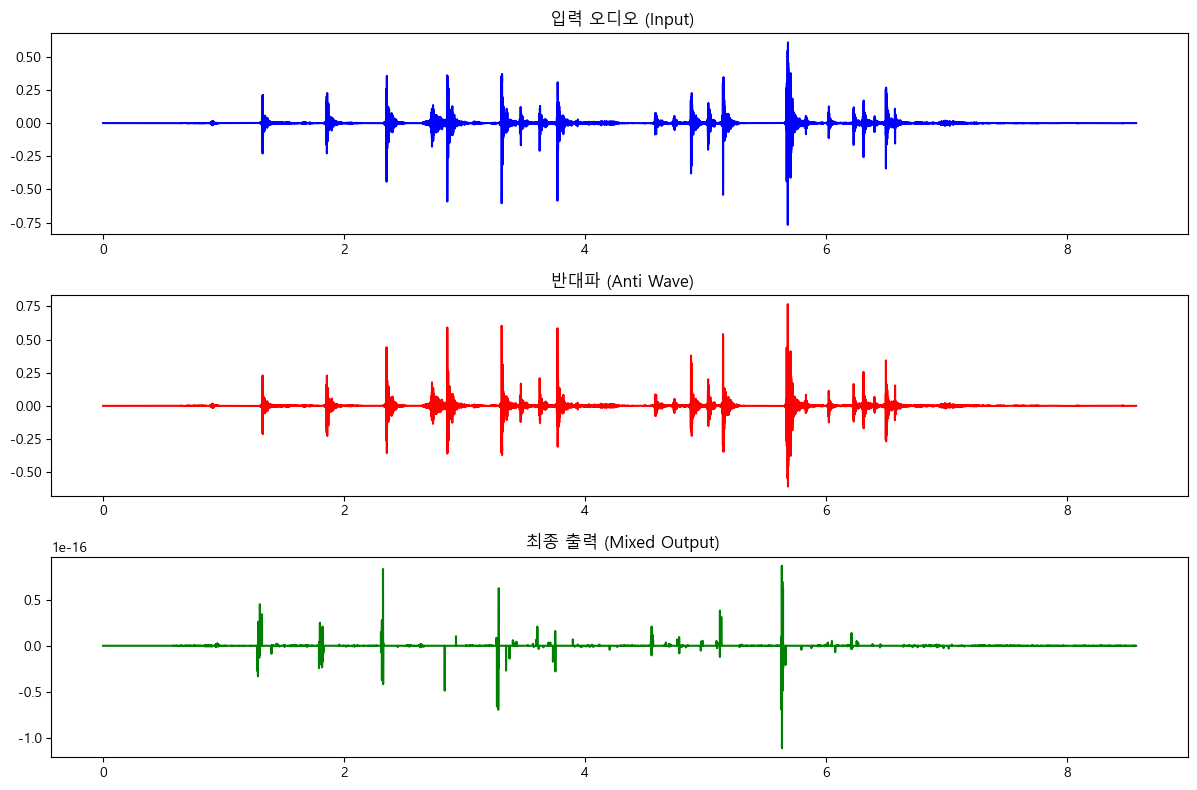

SystemExit: 0

In [25]:
import numpy as np
import sounddevice as sd
import time
import matplotlib.pyplot as plt
import signal
import sys
import matplotlib
import threading

# 한글 폰트 설정
matplotlib.rc('font', family='Malgun Gothic')
matplotlib.rcParams['axes.unicode_minus'] = False

# 오디오 설정
SAMPLE_RATE = 16000
FRAME_SIZE = 1024
DURATION = FRAME_SIZE / SAMPLE_RATE

# 로그 저장
input_audio_log = []
anti_wave_log = []
mixed_audio_log = []

# 반대파 생성 함수
def generate_anti_wave_from_frame(frame):
    fft = np.fft.rfft(frame)
    magnitude = np.abs(fft)
    phase = np.angle(fft)
    anti_fft = magnitude * np.exp(1j * (phase + np.pi))
    anti_wave = np.fft.irfft(anti_fft)
    anti_wave = anti_wave[:len(frame)]
    anti_wave = np.clip(anti_wave, -1, 1)
    return anti_wave.astype(np.float32)

# 오디오 콜백
def audio_callback(indata, outdata, frames, time_info, status):
    global input_audio_log, anti_wave_log, mixed_audio_log

    if status:
        print("Status:", status)

    mono = indata[:, 0]
    anti_wave = generate_anti_wave_from_frame(mono)

    scale = 1.0
    mixed = mono[:frames] + anti_wave[:frames] * scale
    mixed = np.clip(mixed, -1, 1)

    amplify_scale = 2.0  # 증폭 배율, 필요에 따라 조절하세요
    amplified_mixed = np.clip(mixed * amplify_scale, -1, 1)
    stereo_output = np.stack([amplified_mixed[:frames], amplified_mixed[:frames]], axis=1)
    outdata[:] = stereo_output

    input_audio_log.append(mono.copy())
    anti_wave_log.append(anti_wave.copy())
    mixed_audio_log.append(mixed.copy())

# Ctrl+C 종료 시 시각화
def handle_exit(sig, frame):
    print("\n📊 기록된 데이터를 시각화합니다...")
    input_audio = np.concatenate(input_audio_log)
    anti_wave = np.concatenate(anti_wave_log)
    mixed_audio = np.concatenate(mixed_audio_log)
    t = np.linspace(0, len(input_audio) / SAMPLE_RATE, len(input_audio))

    plt.figure(figsize=(12, 8))
    plt.subplot(3, 1, 1)
    plt.plot(t, input_audio, label="Original Input", color="blue")
    plt.title(" 입력 오디오 (Input)")

    plt.subplot(3, 1, 2)
    plt.plot(t, anti_wave, label="Anti Wave", color="red")
    plt.title(" 반대파 (Anti Wave)")

    plt.subplot(3, 1, 3)
    plt.plot(t, mixed_audio, label="Mixed Output", color="green")
    plt.title(" 최종 출력 (Mixed Output)")

    plt.tight_layout()
    plt.show()
    sys.exit(0)

signal.signal(signal.SIGINT, handle_exit)

# 그래프 쓰레드 실행
plot_thread = threading.Thread(daemon=True)
plot_thread.start()

# 스트리밍 시작
print("🔊 실시간 노이즈 캔슬링 시작 (Ctrl+C 종료)")
with sd.Stream(channels=2, callback=audio_callback, samplerate=SAMPLE_RATE, blocksize=FRAME_SIZE):
    while True:
        time.sleep(0.1)

🔊 실시간 노이즈 캔슬링 시작 (Ctrl+C 종료)

📊 기록된 데이터를 시각화합니다...
Status: input overflow, output underflow


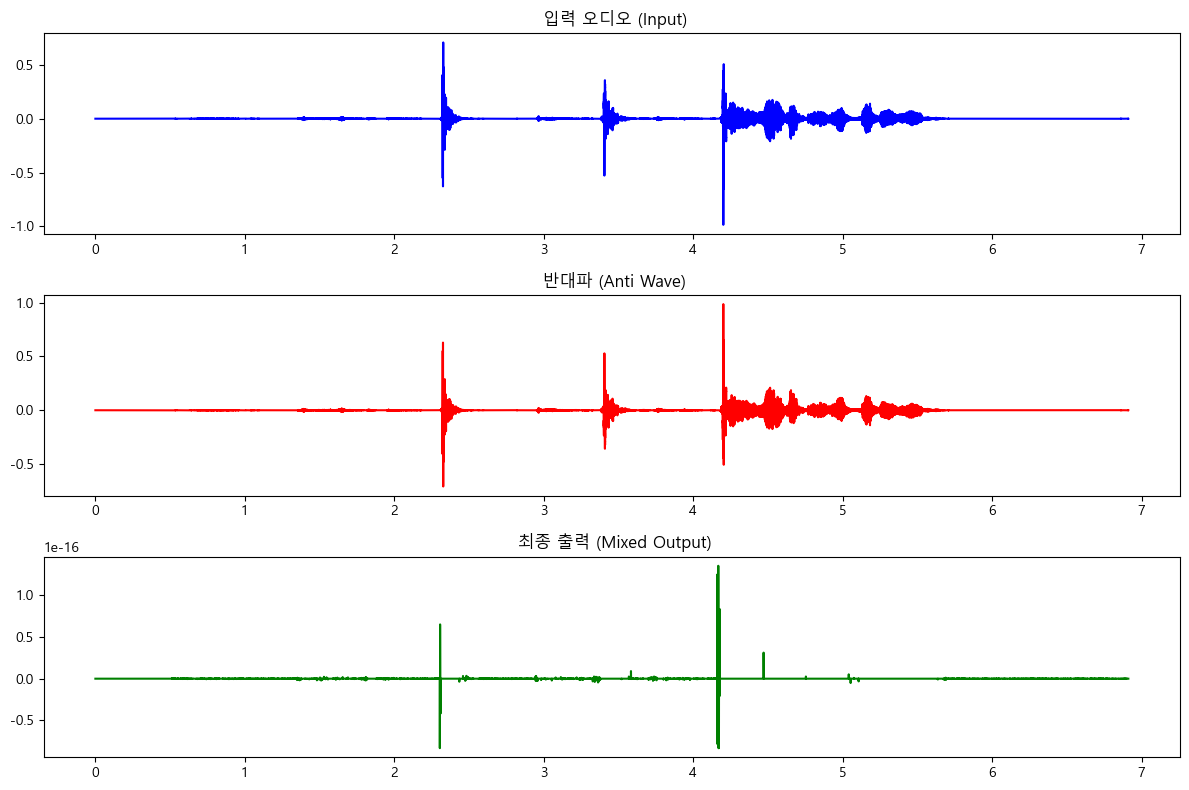

SystemExit: 0

In [24]:
import numpy as np
import sounddevice as sd
import time
import matplotlib.pyplot as plt
import signal
import sys
import matplotlib
import threading

matplotlib.rc('font', family='Malgun Gothic')
matplotlib.rcParams['axes.unicode_minus'] = False

SAMPLE_RATE = 16000
FRAME_SIZE = 1024
DURATION = FRAME_SIZE / SAMPLE_RATE

input_audio_log = []
anti_wave_log = []
mixed_audio_log = []

# 반대파 생성 함수
def generate_anti_wave_from_frame(frame):
    fft = np.fft.rfft(frame)
    magnitude = np.abs(fft)
    phase = np.angle(fft)
    anti_fft = magnitude * np.exp(1j * (phase + np.pi))
    anti_wave = np.fft.irfft(anti_fft)
    anti_wave = anti_wave[:len(frame)]
    anti_wave = np.clip(anti_wave, -1, 1)
    return anti_wave.astype(np.float32)

def audio_callback(indata, outdata, frames, time_info, status):
    global input_audio_log, anti_wave_log, mixed_audio_log

    if status:
        print("Status:", status)

    mono = indata[:, 0]
    anti_wave = generate_anti_wave_from_frame(mono)

    mixed = (mono[:frames] + anti_wave[:frames]) * 1.5
    mixed = np.clip(mixed, -1, 1)

    outdata[:] = mixed.reshape(-1, 1)

    # 로그에 저장
    input_audio_log.append(mono.copy())
    anti_wave_log.append(anti_wave.copy())
    mixed_audio_log.append(mixed.copy())

def handle_exit(sig, frame):
    print("\n📊 기록된 데이터를 시각화합니다...")
    input_audio = np.concatenate(input_audio_log)
    anti_wave = np.concatenate(anti_wave_log)
    mixed_audio = np.concatenate(mixed_audio_log)
    t = np.linspace(0, len(input_audio) / SAMPLE_RATE, len(input_audio))

    plt.figure(figsize=(12, 8))
    plt.subplot(3, 1, 1)
    plt.plot(t, input_audio, label="Original Input", color="blue")
    plt.title(" 입력 오디오 (Input)")
    plt.subplot(3, 1, 2)
    plt.plot(t, anti_wave, label="Anti Wave", color="red")
    plt.title(" 반대파 (Anti Wave)")
    plt.subplot(3, 1, 3)
    plt.plot(t, mixed_audio, label="Mixed Output", color="green")
    plt.title(" 최종 출력 (Mixed Output)")

    plt.tight_layout()
    plt.show()
    sys.exit(0)

signal.signal(signal.SIGINT, handle_exit)

# 그래프 쓰레드 시작
plot_thread = threading.Thread(daemon=True)
plot_thread.start()

print("🔊 실시간 노이즈 캔슬링 시작 (Ctrl+C 종료)")
with sd.Stream(channels=1, callback=audio_callback, samplerate=SAMPLE_RATE, blocksize=FRAME_SIZE):
    while True:
        time.sleep(0.1)